In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#Progress bar
from tqdm import tqdm

#Image pre-processing
from PIL import Image

#For reading CSV and for math
import numpy as np
import pandas as pd

#Visualize some data
import matplotlib.pyplot as plt

#Check our work directory
import os
import shutil

import random

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# Raw dataset analysis

In [4]:
blur_path = r'dataset\blur'
sharp_path = r'dataset\not_blur'

In [6]:
#Analyzing resolutions of dataset

resolutions_blur = []
for filename in tqdm(os.listdir(blur_path)):
    file_path = os.path.join(blur_path, filename)
    im = Image.open(file_path)
    width, size = im.size
    resolutions_blur.append((width, size))

resolutions_sharp = []
for filename in tqdm(os.listdir(sharp_path)):
    file_path = os.path.join(sharp_path, filename)
    im = Image.open(file_path)
    width, size = im.size
    resolutions_sharp.append((width, size))

resolutions_blur.sort()
resolutions_sharp.sort()
#print(resolutions)

100%|██████████| 16535/16535 [00:01<00:00, 8828.09it/s]


C:\Users\maxim\AppData\Local\Temp\ipykernel_12232\1999711713.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(categories)
C:\Users\maxim\AppData\Local\Temp\ipykernel_12232\1999711713.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(categories)
C:\Users\maxim\AppData\Local\Temp\ipykernel_12232\1999711713.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(categories)
C:\Users\maxim\AppData\Local\Temp\ipykernel_12232\1999711713.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(categories)


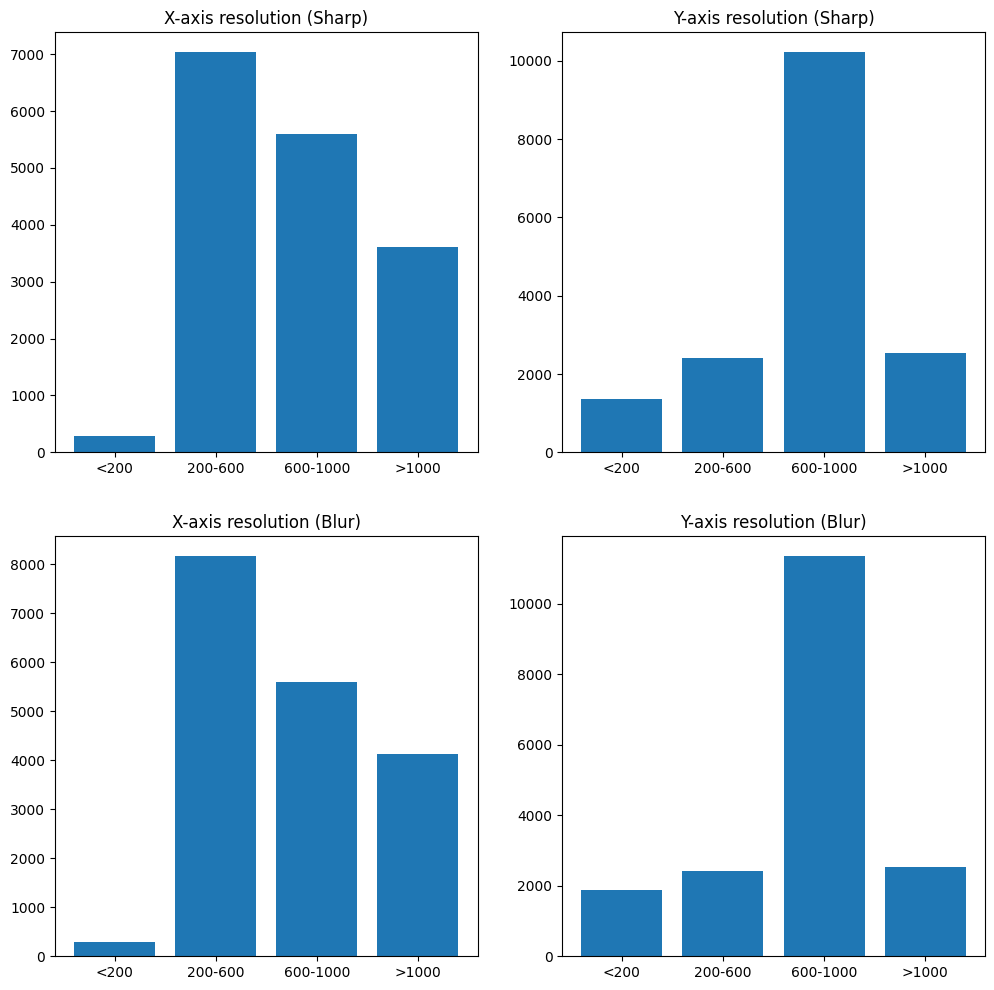

In [7]:
# Get some plots

def get_values(list):
    values_0, values_1 = [0] * 4, [0] * 4
    for i in list:
        if i[0] > 1000:
            values_0[3] += 1
        elif i[0] > 600:
            values_0[2] += 1
        elif i[0] > 200:
            values_0[1] += 1
        else:
            values_0[0] += 1
        
        if i[1] > 1000:
            values_1[0] += 1
        elif i[1] > 600:
            values_1[1] += 1
        elif i[1] > 200:
            values_1[2] += 1
        else:
            values_1[3] += 1

    return values_0, values_1



categories = ['<200', '200-600', '600-1000', '>1000']

values_X_sharp, values_Y_sharp = get_values(resolutions_sharp)
values_X_blur, values_Y_blur = get_values(resolutions_blur)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

ax1.bar(categories, values_X_sharp)
ax1.set_title('X-axis resolution (Sharp)')
ax1.set_xticklabels(categories)

ax2.bar(categories, values_Y_sharp)
ax2.set_title('Y-axis resolution (Sharp)')
ax2.set_xticklabels(categories)

ax3.bar(categories, values_X_blur)
ax3.set_title('X-axis resolution (Blur)')
ax3.set_xticklabels(categories)

ax4.bar(categories, values_Y_blur)
ax4.set_title('Y-axis resolution (Blur)')
ax4.set_xticklabels(categories)


plt.show()

# Data prepreprocessing

In [9]:
def split_files_by_classes(file_list, path):
    # Splitting files into classes / Разбиваем файлы по классам
    class_dict = {'200-': [], '200-600': [], '600-1000': [], '1000+': []}
    for file_name in tqdm(file_list):
        file_path = os.path.join(path, file_name)
        with Image.open(file_path) as img:
            width, height = img.size
            if width < 200:
                class_dict['200-'].append(file_name)
            elif width < 600:
                class_dict['200-600'].append(file_name)
            elif width < 1000:
                class_dict['600-1000'].append(file_name)
            else:
                class_dict['1000+'].append(file_name)
    return class_dict



blur_photos = split_files_by_classes(os.listdir(blur_path), blur_path)
not_blur_photos = split_files_by_classes(os.listdir(sharp_path), sharp_path)

100%|██████████| 16535/16535 [00:01<00:00, 10039.45it/s]


In [10]:
# FIXME: Костыль: создаёт папки внутри blur и not_blur. хз как фиксить 

def create_folders_and_split_files(class_dict, path, label:str, train_val_split = 0.8):
    for class_name, file_list in class_dict.items():
        class_path = os.path.join(path, class_name)
        os.makedirs(os.path.join(class_path, 'train', label), exist_ok=True)
        os.makedirs(os.path.join(class_path, 'test', label), exist_ok=True)

        random.shuffle(file_list)
        split_index = int(len(file_list) * train_val_split)
        train_files = file_list[:split_index]
        test_files = file_list[split_index:]

        for file_name in train_files:
            src_path = os.path.join(path, file_name)
            dst_path = os.path.join(class_path, 'train', label, file_name)
            shutil.copy(src_path, dst_path)
        for file_name in test_files:
            src_path = os.path.join(path, file_name)
            dst_path = os.path.join(class_path, 'test', label, file_name)
            shutil.copy(src_path, dst_path)

create_folders_and_split_files(blur_photos, blur_path, "blur")
create_folders_and_split_files(not_blur_photos, sharp_path, "not_blur")

# Constants

In [3]:
LR = 0.001
BATCH_SIZE = 4
EPOCHS = 15

# Model section

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # input [3, 640, 640]
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),  # [64, 640, 640]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),      # [64, 320, 320]

            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1), # [128, 320, 320]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),      # [128, 160, 160]

            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1), # [256, 160, 160]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),      # [256, 80, 80]

            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1), # [512, 80, 80]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),       # [512, 40, 40]
            
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1), # [512, 40, 40]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),       # [512, 20, 20]
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features = 512*20*20, out_features = 1024),
            nn.ReLU(),
            nn.Linear(in_features = 1024, out_features = 512),
            nn.ReLU(),
            nn.Linear(in_features = 512, out_features = 128), 
            nn.ReLU(), 
            nn.Linear(in_features = 128, out_features = 2)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)
net = Net()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print('Using: ',device)
net.to(device)

# Training and validation section